# Applied Data Science Capstone - The Battle of Neighborhoods Week5

## 1. Introduction of this project - A data journey to London

The other day I received an email from a friend of mine in Japan and he told me he has received an attractive offer from a company in London. He is now planning to relocate with his wife and a 4-year-old boy.
However, he has no experience of living abroad and do not have a clue where to start with finding a right information of the neighborhood there. 
So I have decided to help him with my newly acquired skill of data analysis from the data science course at Coursera.

### Goal of the project: To find suitable accommodation areas inside/around London for a family with a small kid who loves Asian cuisine.

## 2. Data

I first decided to check the crime rate as it is usually the most importatant condition for a family with small children. I also know that they love Asian cuisine and they cannot live without it. So this needs to be taken into account as well.

### Target: Find an area(s) with 1) Low number in criminal cases and 2) Good access to Asian cuisine  (Extra - (if possible) good access to Metro station(s) )

### Data source

#### 1) Criminal Record in London - https://data.london.gov.uk/dataset/recorded_crime_summary (MPS Borough Level Crime in csv format)
#### 2) Geographical coordinate fo Boroughs and Wards in London - https://data.london.gov.uk/dataset/excel-mapping-template-for-london-boroughs-and-wards
#### 3) Neighborhood Venues - with Foursquare API.
#### (4) Location of Metro Stations in London - https://www.doogal.co.uk/london_stations.php (Name of the station, Geographical coordinate(longitute, latititude))

1) Criminal Record in London includes the category of crime, Borough Name and the number of crimes for each month from June.2018 till May, 2020. 

2) Geographical coordinate of Boroughs and Wards in London recquires cleaning as they are not in one file.

## 3. Data Analysis

Importing libraries

In [1]:
import numpy as np 
import pandas as pd

import json
import pycrs

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure #importing Figure artist

from sklearn.cluster import KMeans

import folium # map rendering library


## 3.1 Data Analysis - Criminal Cases data

### Let's start looking at the data set from Crime Data in London

In [2]:
df_crime_csv = pd.read_csv('MPS Borough Level Crime (most recent 24 months).csv')
df_crime_csv.head()

,MajorText,MinorText,LookUp_BoroughName,201806,201807,201808,201809,201810,201811,201812,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Arson and Criminal Damage,Arson,Barking and Dagenham,12,6,5,3,8,5,1,...,3,6,9,8,6,4,5,6,2,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,123,127,101,107,132,105,88,...,118,109,109,97,121,97,103,107,80,88
2,Burglary,Burglary - Business and Community,Barking and Dagenham,33,30,18,33,32,39,33,...,35,37,30,30,25,31,17,28,29,16
3,Burglary,Burglary - Residential,Barking and Dagenham,77,94,84,99,94,106,164,...,67,80,97,114,130,116,123,97,57,41
4,Drug Offences,Drug Trafficking,Barking and Dagenham,6,8,7,10,7,7,4,...,7,7,10,12,3,13,4,6,11,11


In [3]:
df_crime_csv.shape

(1566, 27)

In [4]:
print('There are {} Boroughs in this dataframe.'.format(df_crime_csv['LookUp_BoroughName'].unique().shape[0]))
print('They are {}'.format(df_crime_csv['LookUp_BoroughName'].unique()))

There are 33 Boroughs in this dataframe.
They are ['Barking and Dagenham' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden'
 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'London Heathrow and London City Airports' 'Merton'
 'Newham' 'Redbridge' 'Richmond upon Thames' 'Southwark' 'Sutton'
 'Tower Hamlets' 'Waltham Forest' 'Wandsworth' 'Westminster']


#### Let's check the categories of the crimes

In [5]:
print('There are {} types of Major Crimes in this dataframe.'.format(df_crime_csv['MajorText'].unique().shape[0]))
print('They are {}.'.format(df_crime_csv['MajorText'].unique()))

There are 11 types of Major Crimes in this dataframe.
They are ['Arson and Criminal Damage' 'Burglary' 'Drug Offences'
 'Miscellaneous Crimes Against Society' 'Possession of Weapons'
 'Public Order Offences' 'Robbery' 'Sexual Offences' 'Theft'
 'Vehicle Offences' 'Violence Against the Person'].


In [6]:
print('There are {} sub-categories of crimes in this dataframe.'.format(df_crime_csv['MinorText'].unique().shape[0]))
#print('They are {}.'.format(df_crime_csv['MinorText'].unique()))

There are 53 sub-categories of crimes in this dataframe.


#### Cleaninup the dataframe for visualization

Dropping column of 'MinorText' and swapping Borough and Major Crimes

In [7]:
df_crime_ = df_crime_csv.drop(columns='MinorText',inplace=False)
columns_ = np.array(df_crime_.columns)
columns_[0] = np.array(df_crime_.columns)[1]
columns_[1] = np.array(df_crime_.columns)[0]
columns_

df_crime=df_crime_.reindex(columns=columns_)
df_crime.head()

,LookUp_BoroughName,MajorText,201806,201807,201808,201809,201810,201811,201812,201901,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Barking and Dagenham,Arson and Criminal Damage,12,6,5,3,8,5,1,5,...,3,6,9,8,6,4,5,6,2,2
1,Barking and Dagenham,Arson and Criminal Damage,123,127,101,107,132,105,88,97,...,118,109,109,97,121,97,103,107,80,88
2,Barking and Dagenham,Burglary,33,30,18,33,32,39,33,45,...,35,37,30,30,25,31,17,28,29,16
3,Barking and Dagenham,Burglary,77,94,84,99,94,106,164,114,...,67,80,97,114,130,116,123,97,57,41
4,Barking and Dagenham,Drug Offences,6,8,7,10,7,7,4,5,...,7,7,10,12,3,13,4,6,11,11


In [8]:
df_crime.shape

(1566, 26)

Let's sum up the numbers of criminal case for Major crime categories.

In [9]:
columns_my = np.delete(columns_,[0,1]) #column for the month/year
#len(columns_my)

In [10]:
#row_merged = 33*11
row_merged = df_crime['LookUp_BoroughName'].unique().shape[0] * df_crime['MajorText'].unique().shape[0]
df_crime_Major = pd.DataFrame(index=range(row_merged),columns=columns_).fillna(0)

In [11]:
df_LUBN = df_crime['LookUp_BoroughName'].unique()
df_MT  = df_crime['MajorText'].unique()

In [12]:
for i in range(len(df_LUBN)):
    for j in range(len(df_MT)):
        df_crime_Major.loc[i*len(df_MT)+j,'LookUp_BoroughName'] = df_LUBN[i]
        df_crime_Major.loc[i*len(df_MT)+j,'MajorText'] = df_MT[j]

In [13]:
for k in range(0,df_crime.shape[0]):
    for m in range(len(columns_my)):
        df_crime_Major.loc[
            (df_crime_Major['LookUp_BoroughName']==df_crime.loc[k,'LookUp_BoroughName'])
            &(df_crime_Major['MajorText']==df_crime.loc[k,'MajorText'])
            ,columns_my[m]] += df_crime.loc[k,columns_my[m]]

In [14]:
df_crime_Major.rename(columns={"LookUp_BoroughName":"Borough", "MajorText":"Crime_Category"},inplace=True)

In [99]:
df_crime_Major

,Borough,Crime_Category,201806,201807,201808,201809,201810,201811,201812,201901,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Barking and Dagenham,Arson and Criminal Damage,135,133,106,110,140,110,89,102,...,121,115,118,105,127,101,108,113,82,90
1,Barking and Dagenham,Burglary,110,124,102,132,126,145,197,159,...,102,117,127,144,155,147,140,125,86,57
2,Barking and Dagenham,Drug Offences,75,85,77,82,71,82,73,84,...,81,88,96,106,82,110,111,111,156,189
3,Barking and Dagenham,Miscellaneous Crimes Against Society,21,25,19,17,18,21,15,17,...,33,22,24,28,18,32,18,15,31,22
4,Barking and Dagenham,Possession of Weapons,13,18,18,23,21,18,13,11,...,8,17,15,12,7,24,7,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Westminster,Robbery,243,286,248,270,313,339,414,333,...,373,326,372,330,449,364,339,232,48,36
359,Westminster,Sexual Offences,134,126,131,88,95,101,86,77,...,105,95,87,99,103,101,98,87,43,57
360,Westminster,Theft,2361,2746,2519,2467,2852,3274,3807,3497,...,3618,3343,3887,3762,4232,3396,3807,2267,350,413
361,Westminster,Vehicle Offences,361,347,325,362,440,392,353,485,...,343,362,449,395,475,433,443,317,119,169


#### The data frame of crime numbers are cleaned below.

The data of March, April and May 2020 are dropped as there was already COVID-19 pandemic was going on and the numbers outliers for taking the annual average, minimum and maximum number.

In [19]:
#df_crime_cleaned = df_crime_Major.drop(columns={'202003','202004','202005'})
df_crime_cleaned = df_crime_Major

Let's see how many crime cases each Borough has by accumulating all the cases of crime categories.

In [21]:
columns_df_crime_cleaned = df_crime_cleaned.columns
columns_my_ = np.delete(columns_df_crime_cleaned,[0,1])
columns_my_

Index(['201806', '201807', '201808', '201809', '201810', '201811', '201812',
       '201901', '201902', '201903', '201904', '201905', '201906', '201907',
       '201908', '201909', '201910', '201911', '201912', '202001', '202002',
       '202003', '202004', '202005'],
      dtype='object')

In [22]:
#Preparation of blank data frame : df_borough
df_borough = pd.DataFrame(index=range(df_crime_cleaned['Borough'].unique().shape[0]),columns=columns_df_crime_cleaned).fillna(0)

for i in range(len(df_crime_cleaned['Borough'].unique())):
    df_borough.loc[i,'Borough'] = df_crime_cleaned['Borough'].unique()[i]

df_borough.drop(columns='Crime_Category',inplace=True)
#df_borough

In [105]:
df_crime_cleaned_ = df_crime_cleaned.drop(columns='Crime_Category')
df_crime_cleaned

,Borough,Crime_Category,201806,201807,201808,201809,201810,201811,201812,201901,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Barking and Dagenham,Arson and Criminal Damage,135,133,106,110,140,110,89,102,...,121,115,118,105,127,101,108,113,82,90
1,Barking and Dagenham,Burglary,110,124,102,132,126,145,197,159,...,102,117,127,144,155,147,140,125,86,57
2,Barking and Dagenham,Drug Offences,75,85,77,82,71,82,73,84,...,81,88,96,106,82,110,111,111,156,189
3,Barking and Dagenham,Miscellaneous Crimes Against Society,21,25,19,17,18,21,15,17,...,33,22,24,28,18,32,18,15,31,22
4,Barking and Dagenham,Possession of Weapons,13,18,18,23,21,18,13,11,...,8,17,15,12,7,24,7,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Westminster,Robbery,243,286,248,270,313,339,414,333,...,373,326,372,330,449,364,339,232,48,36
359,Westminster,Sexual Offences,134,126,131,88,95,101,86,77,...,105,95,87,99,103,101,98,87,43,57
360,Westminster,Theft,2361,2746,2519,2467,2852,3274,3807,3497,...,3618,3343,3887,3762,4232,3396,3807,2267,350,413
361,Westminster,Vehicle Offences,361,347,325,362,440,392,353,485,...,343,362,449,395,475,433,443,317,119,169


In [24]:
for k in range(0,df_crime_cleaned_.shape[0]):
    for m in range(len(columns_my_)):
        df_borough.loc[
            df_borough['Borough']==df_crime_cleaned_.loc[k,'Borough']
            ,columns_my_[m]] += df_crime_cleaned_.loc[k,columns_my_[m]]

In [310]:
df_borough_s = df_borough
df_borough_s['Ave.'] = df_borough_s[columns_my_].mean(axis=1)
df_borough_s

,Borough,201806,201807,201808,201809,201810,201811,201812,201901,201902,...,201909,201910,201911,201912,202001,202002,202003,202004,202005,Ave.
0,Barking and Dagenham,1569,1612,1460,1468,1584,1562,1544,1581,1576,...,1644,1790,1658,1654,1668,1579,1793,1269,1433,1613.041667
1,Barnet,2346,2368,2244,2264,2550,2561,2421,2412,2545,...,2610,2629,2830,2605,2641,2593,2302,1658,1970,2478.500000
2,Bexley,1334,1238,1243,1263,1341,1412,1467,1543,1348,...,1491,1673,1536,1402,1619,1461,1284,904,1209,1409.666667
3,Brent,2697,2750,2510,2556,2728,2731,2388,2491,2372,...,2563,2661,2505,2422,2511,2386,2266,2025,2214,2508.041667
4,Bromley,2015,1927,1854,1941,1970,1989,1992,1999,1953,...,2118,2223,2294,2089,2146,2071,1764,1444,1635,1997.083333
5,Camden,3024,3114,2859,2895,3057,3138,2965,3060,3172,...,3348,3738,3456,3190,3226,3451,2713,1628,1847,3070.500000
6,Croydon,2427,2706,2579,2515,2813,2621,2646,2641,2569,...,2893,3074,2987,2770,3058,2905,2982,2237,2492,2742.708333
7,Ealing,2294,2514,2277,2420,2554,2595,2292,2551,2464,...,2642,2722,2815,2603,2691,2429,2358,1984,2256,2520.041667
8,Enfield,2375,2372,2284,2295,2442,2501,2372,2507,2344,...,2547,2670,2807,2540,2593,2475,2365,1852,2193,2444.458333
9,Greenwich,2216,2277,2085,2238,2280,2241,2259,2240,2052,...,2570,2496,2500,2196,2370,2301,2056,1647,2045,2286.041667


In [318]:
df_borough_s.sort_values(by=['Ave.'],ascending=True).head(6)

,Borough,201806,201807,201808,201809,201810,201811,201812,201901,201902,...,201909,201910,201911,201912,202001,202002,202003,202004,202005,Ave.
22,London Heathrow and London City Airports,286,312,280,277,276,252,286,248,267,...,309,325,280,326,286,292,267,54,38,269.958333
19,Kingston upon Thames,953,1095,1127,1027,1191,1124,1008,1050,1033,...,1084,1073,1131,1054,1124,1052,905,682,813,1054.625000
26,Richmond upon Thames,1011,1210,1087,1014,1156,1201,1008,1040,975,...,1034,1109,1199,1092,1145,1026,932,720,969,1058.750000
28,Sutton,1038,1083,999,968,1060,1021,1093,1121,1138,...,1115,1198,1209,1129,1355,1203,1187,862,1010,1117.750000
23,Merton,1123,1163,1149,1103,1244,1215,1228,1220,1052,...,1226,1242,1289,1118,1274,1120,1127,884,977,1171.458333
13,Harrow,1243,1381,1144,1232,1392,1404,1320,1453,1342,...,1445,1578,1439,1426,1517,1448,1353,1039,1182,1375.666667


### The data above shows that top 6 boroughs which have lowest crime numbers in average . Following analysis will exclude the most safe area, London Heathrow and London City Airport, as it's highly likely not the place for common accommodations.

#### Let's try some visualization of the top 5 "safe" boroughs.

In [26]:
df_borough_t5 = df_borough_s.sort_values(by=['Ave.'],ascending=True).head(6).drop([22])
df_borough_t5.set_index('Borough',inplace=True)
df_borough_t5.drop(columns='Ave.',inplace=True)
df_borough_t5

,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
Borough,,,,,,,,,,,,,,,,,,,,,
Kingston upon Thames,953,1095,1127,1027,1191,1124,1008,1050,1033,1149,...,1078,1084,1073,1131,1054,1124,1052,905,682,813
Richmond upon Thames,1011,1210,1087,1014,1156,1201,1008,1040,975,1125,...,1020,1034,1109,1199,1092,1145,1026,932,720,969
Sutton,1038,1083,999,968,1060,1021,1093,1121,1138,1136,...,1227,1115,1198,1209,1129,1355,1203,1187,862,1010
Merton,1123,1163,1149,1103,1244,1215,1228,1220,1052,1248,...,1277,1226,1242,1289,1118,1274,1120,1127,884,977
Harrow,1243,1381,1144,1232,1392,1404,1320,1453,1342,1446,...,1367,1445,1578,1439,1426,1517,1448,1353,1039,1182


In [27]:
labels_t5 = df_borough_t5.columns
#labels_t5

In [28]:
df_borough_t5_t=df_borough_t5.T
#df_borough_t5_t

In [29]:
#color for Richmond upon Thames - light purple #bfa1d8
cr_rt = round(int("0xbf",0)/256.0,2)
cg_rt = round(int("0xa1",0)/256.0,2)
cb_rt = round(int("0xd8",0)/256.0,2)

#color for Kingston upon Thames - olive #819c8b
cr_kt = round(int("0x81",0)/256.0,2)
cg_kt = round(int("0x9c",0)/256.0,2)
cb_kt = round(int("0x8b",0)/256.0,2)

#color for Sutton - light blue
cr_s = round(int("0xa9",0)/256.0,2)
cg_s = round(int("0xcd",0)/256.0,2)
cb_s = round(int("0xc7",0)/256.0,2)

#color for Merton - dark purple 
cr_m = round(int("0x76",0)/256.0,2)
cg_m = round(int("0x5c",0)/256.0,2)
cb_m = round(int("0x9f",0)/256.0,2)

#color for Harrow - orange #fa7268
cr_h = round(int("0xfa",0)/256.0,2)
cg_h = round(int("0x72",0)/256.0,2)
cb_h = round(int("0x68",0)/256.0,2)

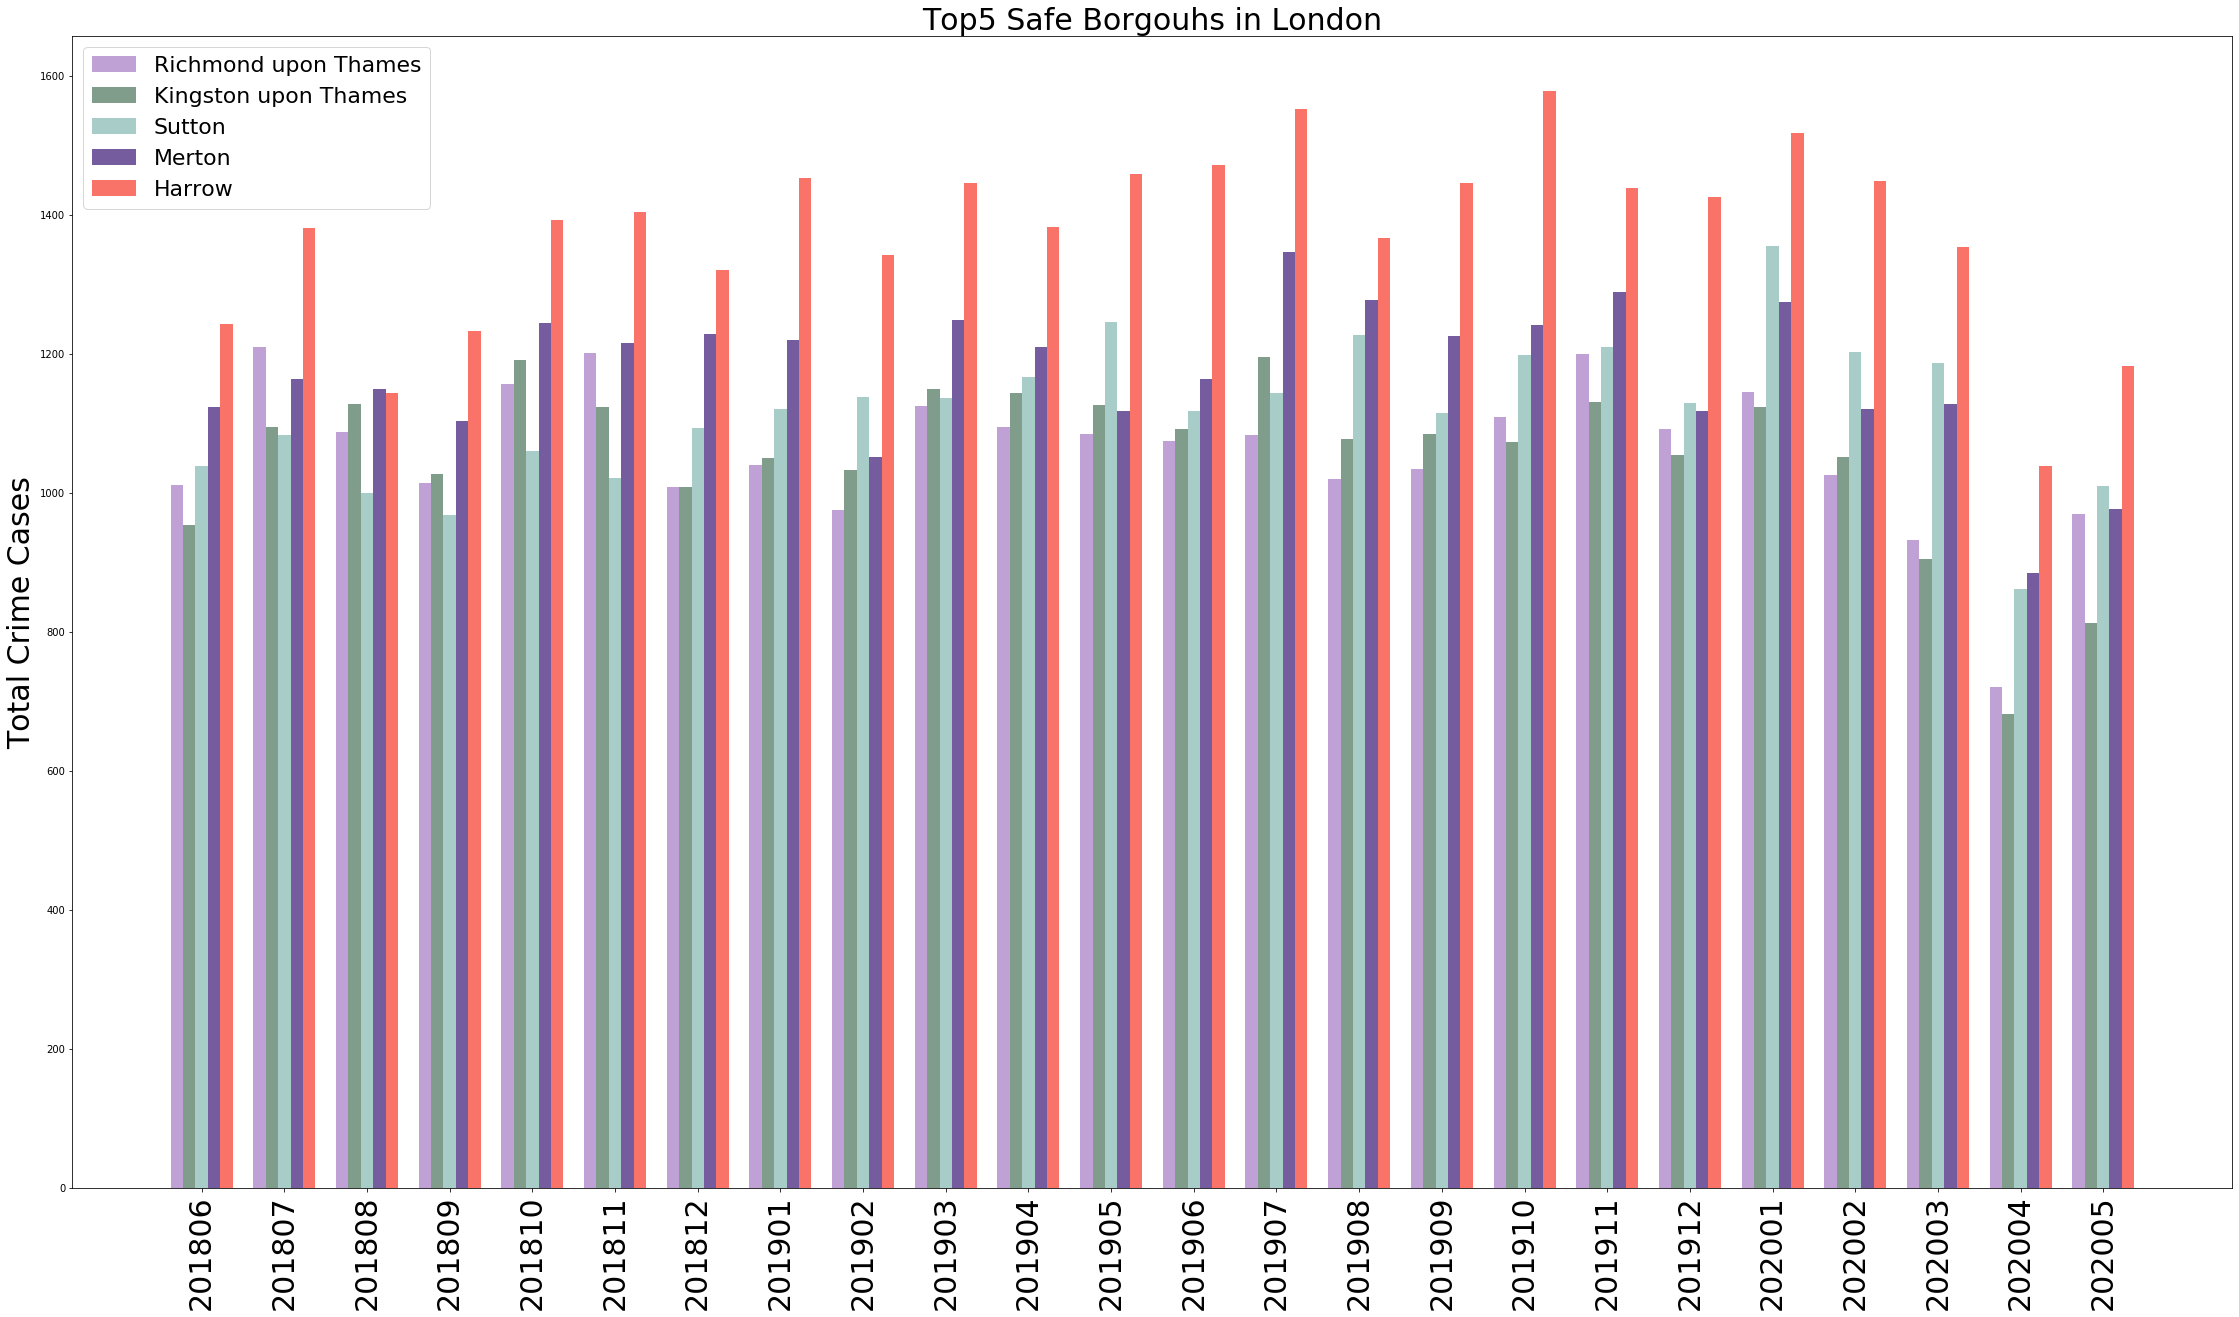

In [30]:
Xnum = df_borough_t5_t.shape[0]
X = np.arange(Xnum)
w = 0.15
xticks_g = labels_t5

plt.rcParams['figure.figsize']=(30.0,16.0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

#Graph title
plt.title('Top5 Safe Borgouhs in London',fontsize=30)

#coloring the bars
ax.bar(X-2*w, df_borough_t5_t['Richmond upon Thames'], width = w, color=(cr_rt,cg_rt,cb_rt,1))
ax.bar(X-w,   df_borough_t5_t['Kingston upon Thames'], width = w, color=(cr_kt,cg_kt,cb_kt,1))
ax.bar(X,     df_borough_t5_t['Sutton'], width = w, color=(cr_s,cg_s,cb_s,1))
ax.bar(X+w,   df_borough_t5_t['Merton'], width = w, color=(cr_m,cg_m,cb_m,1))
ax.bar(X+2*w, df_borough_t5_t['Harrow'], width = w, color=(cr_h,cg_h,cb_h,1))


#for ticks
plt.xticks(X,xticks_g,rotation=90)
ax.set_xticklabels(xticks_g, rotation=90, fontsize=30.0)
ax.set_ylabel('Total Crime Cases',rotation=90, fontsize=30.0)

#for legend
Interests = ['Richmond upon Thames','Kingston upon Thames','Sutton','Merton','Harrow']
plt.legend(Interests, loc=2,fontsize=22)


#values above bars
#for i in ax.patches:
#    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2)), fontsize=6)
    
plt.show()

### It looks April and May 2020 have relatively large drops of the criminal cases especially for top 3 boroughs. This is probably because of the lock-down of London City due to Covid-19. Besiedes that, the seasonal tendency of the ciriminal cases are quite similar in all top 5 borouhgs.

###  In order to focus on choosing the right place for my friend, I pick up Righmond upon Thames which is shown to be the safest place in London. Just in case there is no good result of Asian food restaurant from Foursquare, I'll choose to analyse around Kingston upon Thames.

## 3.2 Data Analysis - Geographical Coordinates

Importing the csv file that contains the name of Ward, longitude and latitude, and cleaning up the data frame.

In [128]:
df_geo_xls = pd.read_excel('Mapping-template-london-ward-map-2018.xls')
df_geo_xls.head()

,Code,Ward name,Borough name,shape,Values,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,E05000026,Abbey,Barking and Dagenham,NaN,128.292,NaN,NaN,NaN,NaN,NaN
1,E05000027,Alibon,Barking and Dagenham,NaN,136.442,NaN,NaN,NaN,NaN,NaN
2,E05000028,Becontree,Barking and Dagenham,NaN,128.809,NaN,NaN,NaN,NaN,NaN
3,E05000029,Chadwell Heath,Barking and Dagenham,NaN,338.422,NaN,NaN,NaN,NaN,NaN
4,E05000030,Eastbrook,Barking and Dagenham,NaN,345.060,NaN,NaN,NaN,NaN,NaN


In [129]:
df_geo_ = df_geo_xls.drop(columns=['shape','Values','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'])
df_geo_.rename(columns={"Ward name":"Ward", "Borough name":"Borough"},inplace=True)
df_geo_ = df_geo_.reindex(columns=['Code','Borough','Ward'])
df_geo = df_geo_.loc[df_geo_['Borough'].isin(['Richmond upon Thames','Kingston upon Thames'])]
df_geo.reset_index(drop=True,inplace=True)
#df_geo

In [130]:
df_geo_csv = pd.read_csv('Wards__December_2017__Boundaries_in_the_UK__WGS84_.csv')
df_geo_csv.head()
df_coord = df_geo_csv.drop(columns=['objectid','wd17nmw','bng_e','bng_n','st_areashape','st_lengthshape'])
df_coord.rename(columns={"wd17cd":"Code","wd17nm":"Ward"},inplace=True)
print(df_coord.shape)
df_coord

(9131, 4)


,Code,Ward,long,lat
0,E05000026,Abbey,0.081291,51.539799
1,E05000027,Alibon,0.150987,51.545898
2,E05000028,Becontree,0.116912,51.552601
3,E05000029,Chadwell Heath,0.138596,51.583401
4,E05000030,Eastbrook,0.173453,51.555199
...,...,...,...,...
9126,W05001034,Seven Sisters,-3.708120,51.758598
9127,W05001035,Tai-bach,-3.754750,51.586201
9128,W05001036,Broughton South,-2.994000,53.159801
9129,W05001037,Penally,-4.726920,51.675701


#### This dataframe of df_coord has too many data and most of them are unneccessary. It needs to be cut before mirroring longitude and latitude values to df_geo.

In [131]:
df_coord_ = df_coord.sort_values(by=['Code'],ascending=True).iloc[300:500]
df_coord_.reset_index(drop=True,inplace=True)
df_coord_

,Code,Ward,long,lat
0,E05000345,Yiewsley,-0.46279,51.517101
1,E05000346,Bedfont,-0.44177,51.452400
2,E05000347,Brentford,-0.29747,51.493000
3,E05000348,Chiswick Homefields,-0.25698,51.477402
4,E05000349,Chiswick Riverside,-0.27168,51.481998
...,...,...,...,...
195,E05000558,Carshalton Central,-0.16921,51.364399
196,E05000559,Carshalton South and Clockhouse,-0.16397,51.344601
197,E05000560,Cheam,-0.21549,51.350201
198,E05000561,Nonsuch,-0.23857,51.371700


In [192]:
for k in range(df_coord_.shape[0]):
    df_geo.loc[df_geo['Code']==df_coord_.loc[k,'Code'],'longitude'] = df_coord_.loc[k,'long']
    df_geo.loc[df_geo['Code']==df_coord_.loc[k,'Code'],'latitude'] = df_coord_.loc[k,'lat']

/home/ryo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [319]:
df_geo.shape

(34, 5)

## 4. Explore around Richmond upon Thames and Kingston upon Thames

The necessary data is prepared in the last section. So let's explore around the intereseted areas!

#### Let's see it on the map.

In [151]:
#Take the middle of Richmond and Kingston
lat_rtkt = (51.4613 + 51.4103)/2
lon_rtkt = (-0.3037 - 0.2995) /2

In [235]:
# create map around Richimond and Kingston using latitude and longitude values
map_rt = folium.Map(location=[lat_rtkt, lon_rtkt], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_geo['latitude'], df_geo['longitude'], df_geo['Borough'], df_geo['Ward']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#2233cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rt)
    
map_rt

#### Define Foursquare Credentials and Version

In [133]:
CLIENT_ID = 'TKC5I1TJWMRGIADZYG14FAZWYPD1IGKNZ5EWK4PTQJUSACLS' # your Foursquare ID
CLIENT_SECRET = 'N2LTPZHIYBAGUR1PGDUSLREYTE1OXCL2HZBJLVSZ3BFFJSWE' # your Foursquare Secret
VERSION = '20200110' #let's see the situation before Covid-19
LIMIT = 30 #Original Limit
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TKC5I1TJWMRGIADZYG14FAZWYPD1IGKNZ5EWK4PTQJUSACLS
CLIENT_SECRET:N2LTPZHIYBAGUR1PGDUSLREYTE1OXCL2HZBJLVSZ3BFFJSWE


#### Function to repeat acquiring the nearby venues for all neighborhood

In [160]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [161]:
venues_rtkt = getNearbyVenues(names=df_geo['Ward'],
                                   latitudes =df_geo['latitude'],
                                   longitudes=df_geo['longitude']
                                  )

Alexandra
Berrylands
Beverley
Canbury
Chessington North And Hook
Chessington South
Coombe Hill
Coombe Vale
Grove
Norbiton
Old Malden
St. James
St. Mark's
Surbiton Hill
Tolworth And Hook Rise
Tudor
Barnes
East Sheen
Fulwell and Hampton Hill
Ham, Petersham and Richmond Riverside
Hampton
Hampton North
Hampton Wick
Heathfield
Kew
Mortlake and Barnes Common
North Richmond
St. Margaret's and North Twickenham
South Richmond
South Twickenham
Teddington
Twickenham Riverside
West Twickenham
Whitton


In [162]:
venues_rtkt.shape

(322, 7)

In [163]:
venues_rtkt.head()

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra,51.386101,-0.27618,"Cornerhouse Theatre, Douglas Road",51.386059,-0.282649,Theater
1,Berrylands,51.392200,-0.29184,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
2,Berrylands,51.392200,-0.29184,Jean's Cafe,51.393214,-0.296070,Coffee Shop
3,Berrylands,51.392200,-0.29184,Prince of Wales,51.389642,-0.297580,Pub
4,Berrylands,51.392200,-0.29184,Surbiton Karate,51.394300,-0.298155,Martial Arts Dojo


#### Show how many venues are returned

In [186]:
venues_rtkt.groupby('Ward').count().head()

,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Ward,,,,,,
Alexandra,1,1,1,1,1,1
Barnes,3,3,3,3,3,3
Berrylands,4,4,4,4,4,4
Beverley,20,20,20,20,20,20
Canbury,5,5,5,5,5,5


In [165]:
print('There are {} uniques categories.'.format(len(venues_rtkt['Venue Category'].unique())))

There are 95 uniques categories.


### Analyize each Ward

In [172]:
# one hot encoding
rtkt_onehot = pd.get_dummies(venues_rtkt[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rtkt_onehot['Ward'] = venues_rtkt['Ward'] 

# move neighborhood column to the first column
fixed_columns = [rtkt_onehot.columns[-1]] + list(rtkt_onehot.columns[:-1])
rtkt_onehot = rtkt_onehot[fixed_columns]

#rtkt_onehot

In [238]:
#rtkt_onehot.columns

#### Group rows by Ward and by taking the mean of the frequency of occurrence of each category

In [174]:
rtkt_grouped = rtkt_onehot.groupby('Ward').mean().reset_index()
#rtkt_grouped

In [176]:
num_top_venues = 5

for hood in rtkt_grouped['Ward']:
    print("----"+hood+"----")
    temp = rtkt_grouped[rtkt_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alexandra----
                      venue  freq
0                   Theater   1.0
1               Art Gallery   0.0
2  Mediterranean Restaurant   0.0
3        Photography Studio   0.0
4                  Pharmacy   0.0


----Barnes----
                      venue  freq
0                      Lake  0.67
1           Nature Preserve  0.33
2               Art Gallery  0.00
3  Mediterranean Restaurant  0.00
4        Photography Studio  0.00


----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.25
1                   Pub  0.25
2           Coffee Shop  0.25
3     Martial Arts Dojo  0.25
4           Art Gallery  0.00


----Beverley----
                 venue  freq
0    Korean Restaurant  0.20
1          Supermarket  0.10
2             Gym Pool  0.05
3                 Café  0.05
4  Japanese Restaurant  0.05


----Canbury----
               venue  freq
0                Pub   0.4
1  Fish & Chips Shop   0.2
2          Gastropub   0.2
3               Café   0.2
4        A

In [177]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe with the topc 10 venues for each neighborhood

In [209]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
rtkt_venues_sorted = pd.DataFrame(columns=columns)
rtkt_venues_sorted['Ward'] = rtkt_grouped['Ward']

for ind in np.arange(rtkt_grouped.shape[0]):
    rtkt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rtkt_grouped.iloc[ind, :], num_top_venues)

#rtkt_venues_sorted

In [210]:
rtkt_venues_sorted.shape

(34, 11)

### Clustering Wards

In [211]:
# set number of clusters
kclusters = 5

rtkt_grouped_clustering = rtkt_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rtkt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 2, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 0],
      dtype=int32)

#### Creat a new dataframe that includes the cluster as well as the top 5 venues for each Ward

In [212]:
# add clustering labels
rtkt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [213]:
rtkt_data_merged = df_geo

# merge rtkt_grouped with df_geo to add latitude/longitude for each neighborhood
rtkt_data_merged = rtkt_data_merged.join(rtkt_venues_sorted.set_index('Ward'), on='Ward')

rtkt_data_merged.drop(columns='Code',inplace=True)

In [247]:
rtkt_data_merged.head()

,Borough,Ward,longitude,latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kingston upon Thames,Alexandra,-0.27618,51.386101,4,Theater,Wine Shop,Food,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
1,Kingston upon Thames,Berrylands,-0.29184,51.392200,3,Gym / Fitness Center,Coffee Shop,Pub,Martial Arts Dojo,Flower Shop,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field
2,Kingston upon Thames,Beverley,-0.25080,51.403900,0,Korean Restaurant,Supermarket,Gym Pool,Café,Grocery Store,Gym / Fitness Center,Indian Restaurant,Japanese Restaurant,Karaoke Bar,Fast Food Restaurant
3,Kingston upon Thames,Canbury,-0.29589,51.417702,3,Pub,Gastropub,Café,Fish & Chips Shop,Wine Shop,Flower Shop,Department Store,Diner,Exhibit,Farmers Market
4,Kingston upon Thames,Chessington North And Hook,-0.30792,51.369499,0,Park,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,Food,Diner,Exhibit,Farmers Market


### Let's see the claster on the map

In [320]:
# create map
map_clusters = folium.Map(location=[lat_rtkt, lon_rtkt], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rtkt_data_merged['latitude'], rtkt_data_merged['longitude'], rtkt_data_merged['Ward'], rtkt_data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Examin Clusters

In [252]:
venues_rtkt['Venue Category'].unique()

array(['Theater', 'Gym / Fitness Center', 'Coffee Shop', 'Pub',
       'Martial Arts Dojo', 'Park', 'Café', 'Supermarket',
       'Korean Restaurant', 'Indian Restaurant', 'Gym Pool',
       'Karaoke Bar', 'Gastropub', 'Sushi Restaurant', 'Grocery Store',
       'Japanese Restaurant', 'Department Store', 'Fast Food Restaurant',
       'Bookstore', 'Fish & Chips Shop', 'Bakery', 'Soccer Field',
       'BBQ Joint', 'Exhibit', 'Hotel', 'Restaurant',
       'Construction & Landscaping', 'Bus Station',
       'Financial or Legal Service', 'Burger Joint', 'Breakfast Spot',
       'Hookah Bar', 'Bar', 'Bus Stop', 'Soccer Stadium',
       'Rental Car Location', 'Fried Chicken Joint', 'Food', 'Food Truck',
       'Steakhouse', 'Train Station', 'Tennis Court', 'Bistro',
       'Tea Room', 'Thai Restaurant', 'French Restaurant',
       'Deli / Bodega', 'Pet Café', 'Farmers Market', 'Pharmacy',
       'Chinese Restaurant', 'Italian Restaurant', 'Diner',
       'Climbing Gym', 'Gym', 'Field', 'Harb

#### The venues of 'Korean Restaurant', 'Indian Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Thai Restaurant', 'Chinese Restaurant' are fare to be considered as Asian cuisin in my defiition. Let's check if there is any cluster that shows to have these venues.

In [254]:
venue_asian = ['Korean Restaurant', 'Indian Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Thai Restaurant', 'Chinese Restaurant']

Cluster 0

In [295]:
df_c0=rtkt_data_merged.loc[rtkt_data_merged['Cluster Labels'] == 0, rtkt_data_merged.columns[[1] + list(range(5, rtkt_data_merged.shape[1]))]]

In [300]:
df_c0.reset_index(drop=True,inplace=True)
df_c0

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beverley,Korean Restaurant,Supermarket,Gym Pool,Café,Grocery Store,Gym / Fitness Center,Indian Restaurant,Japanese Restaurant,Karaoke Bar,Fast Food Restaurant
1,Chessington North And Hook,Park,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,Food,Diner,Exhibit,Farmers Market
2,Chessington South,Exhibit,BBQ Joint,Soccer Field,Wine Shop,Food,Department Store,Diner,Farmers Market,Fast Food Restaurant,Field
3,Coombe Hill,Hotel,Restaurant,Wine Shop,Flower Shop,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field
4,Coombe Vale,Construction & Landscaping,Grocery Store,Financial or Legal Service,Bus Station,Flower Shop,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant
5,Norbiton,Soccer Stadium,Gym / Fitness Center,Fried Chicken Joint,Hotel,Indian Restaurant,Food Truck,Breakfast Spot,Rental Car Location,Food,Fish & Chips Shop
6,Old Malden,Japanese Restaurant,Train Station,Grocery Store,Park,Bakery,Steakhouse,Flower Shop,Diner,Exhibit,Farmers Market
7,Tolworth And Hook Rise,Soccer Field,Gym,Climbing Gym,Gym / Fitness Center,Golf Course,Fish & Chips Shop,Department Store,Diner,Grocery Store,Exhibit
8,East Sheen,Café,Lake,Athletics & Sports,Racetrack,Wine Shop,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field
9,"Ham, Petersham and Richmond Riverside",Golf Course,Tea Room,Garden,Bus Station,Wine Shop,Flower Shop,Department Store,Diner,Exhibit,Farmers Market


In [302]:
df_c0_asian = df_c0.iloc[[0,1,5,6,11,15],0:11]

Cluseter lable : 1

In [222]:
rtkt_data_merged.loc[rtkt_data_merged['Cluster Labels'] == 1, rtkt_data_merged.columns[[1] + list(range(5, rtkt_data_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,St. James,Tennis Court,Bus Stop,Wine Shop,Food,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field


Cluseter lable : 2

In [223]:
rtkt_data_merged.loc[rtkt_data_merged['Cluster Labels'] == 2, rtkt_data_merged.columns[[1] + list(range(5, rtkt_data_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Barnes,Lake,Nature Preserve,Gym,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


Cluster lable : 3

In [304]:
df_c3=rtkt_data_merged.loc[rtkt_data_merged['Cluster Labels'] == 3, rtkt_data_merged.columns[[1] + list(range(5, rtkt_data_merged.shape[1]))]]

In [305]:
df_c3.reset_index(drop=True,inplace=True)
df_c3

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Coffee Shop,Pub,Martial Arts Dojo,Flower Shop,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field
1,Canbury,Pub,Gastropub,Café,Fish & Chips Shop,Wine Shop,Flower Shop,Department Store,Diner,Exhibit,Farmers Market
2,Grove,Pub,Park,Hotel,Grocery Store,Fish & Chips Shop,Bus Stop,Breakfast Spot,Burger Joint,Bar,Hookah Bar
3,St. Mark's,Coffee Shop,Pub,Grocery Store,Pharmacy,Breakfast Spot,Gym / Fitness Center,French Restaurant,Indian Restaurant,Fish & Chips Shop,Farmers Market
4,Surbiton Hill,Pub,Indian Restaurant,Park,Grocery Store,Diner,Bar,Café,Italian Restaurant,Restaurant,Fish & Chips Shop
5,Tudor,Harbor / Marina,Pub,Italian Restaurant,Field,Wine Shop,Flower Shop,Department Store,Diner,Exhibit,Farmers Market
6,Fulwell and Hampton Hill,Grocery Store,Butcher,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Pub,Chinese Restaurant,Wine Shop,Bistro,Boat or Ferry
7,Hampton North,Photography Studio,Playground,Pub,Supermarket,Financial or Legal Service,Convenience Store,Deli / Bodega,Department Store,Diner,Exhibit
8,Hampton Wick,Park,Fish & Chips Shop,Athletics & Sports,Theater,Thai Restaurant,Waste Facility,Pub,Business Service,Bus Stop,Department Store
9,Mortlake and Barnes Common,Athletics & Sports,Pub,Restaurant,Grocery Store,Sports Club,Coffee Shop,Café,Bus Stop,Park,Tea Room


In [306]:
df_c3_asian = df_c3.iloc[[3,6,10,11],0:11]

Cluster lable : 4

In [294]:
rtkt_data_merged.loc[rtkt_data_merged['Cluster Labels'] == 4, rtkt_data_merged.columns[[1] + list(range(5, rtkt_data_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alexandra,Theater,Wine Shop,Food,Department Store,Diner,Exhibit,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


## Results and Conclusion

By looking throug the clusters, it is quite obvious that the venues in Cluster1,2,4 have little relevance to Asian restaurants. Below are the extracted list of venues of Cluster 0 and 3. 


There are some Wards that has one or more of Asian restaurants in the top 10 venues, for example, Beverley and North Ritchmond. The neighborhood of these two Wards can be recommended to my friend.

In [303]:
df_c0_asian

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beverley,Korean Restaurant,Supermarket,Gym Pool,Café,Grocery Store,Gym / Fitness Center,Indian Restaurant,Japanese Restaurant,Karaoke Bar,Fast Food Restaurant
1,Chessington North And Hook,Park,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,Food,Diner,Exhibit,Farmers Market
5,Norbiton,Soccer Stadium,Gym / Fitness Center,Fried Chicken Joint,Hotel,Indian Restaurant,Food Truck,Breakfast Spot,Rental Car Location,Food,Fish & Chips Shop
6,Old Malden,Japanese Restaurant,Train Station,Grocery Store,Park,Bakery,Steakhouse,Flower Shop,Diner,Exhibit,Farmers Market
11,Heathfield,Gym,Soccer Field,Pizza Place,Playground,Indian Restaurant,Convenience Store,Department Store,Diner,Exhibit,Farmers Market
15,Twickenham Riverside,Café,Gastropub,French Restaurant,Art Gallery,Park,Playground,Pub,Chinese Restaurant,Bus Stop,Deli / Bodega


In [307]:
df_c3_asian

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,St. Mark's,Coffee Shop,Pub,Grocery Store,Pharmacy,Breakfast Spot,Gym / Fitness Center,French Restaurant,Indian Restaurant,Fish & Chips Shop,Farmers Market
6,Fulwell and Hampton Hill,Grocery Store,Butcher,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Pub,Chinese Restaurant,Wine Shop,Bistro,Boat or Ferry
10,North Richmond,Garden,Pub,Restaurant,Hotel,Rugby Stadium,Korean Restaurant,Italian Restaurant,Chinese Restaurant,Japanese Restaurant,Food Truck
11,St. Margaret's and North Twickenham,Pub,Comedy Club,Seafood Restaurant,Park,Deli / Bodega,Coffee Shop,Chinese Restaurant,Café,Grocery Store,Boat or Ferry
